# Problem

>   Build a model that classifies the vibrational (time-series) data into the 3 states.

> **EDA of sample data**

>>  Includes periods of OFF, ACTIVE, IDLE

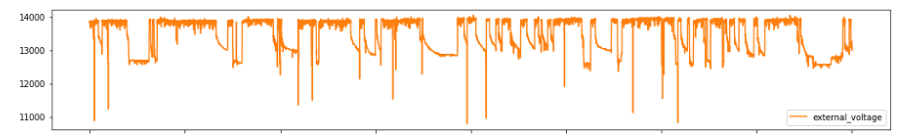

# Data from a car (ev) engine

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('sample_data.csv')
print(data.shape)
data.sample(5)

(32518, 4)


,Time [s],Velocity [km/h],Acceleration [m/s^2],Battery_Voltage [V]
30478,3047.8,0.00000,0.07130,373.85480
13373,1337.3,122.12547,-0.11436,372.28510
6091,609.1,29.72600,0.06532,384.43578
443,44.3,26.55195,-1.05600,391.25311
11853,1185.3,0.00000,0.11800,384.08476


>> This sample data has 'Acceleration' as a feature. A new feature 'Acceleration_RMS' is computed from the data and reported.

In [ ]:
data['Time [s]'] = pd.to_datetime(data['Time [s]'])
data['Time [s]'] = data.index
#data.dtypes

df = data.drop('Time [s]', axis = 1)
df.sample(5)

,Velocity [km/h],Acceleration [m/s^2],Battery_Voltage [V]
11942,0.00000,0.09800,384.20000
18081,51.01905,0.15076,377.00000
30077,41.78392,-1.65422,379.77342
3385,1.38168,0.15412,387.11503
12720,69.01563,0.01143,379.86241


Text(0.5, 0, 'Time (seconds)')

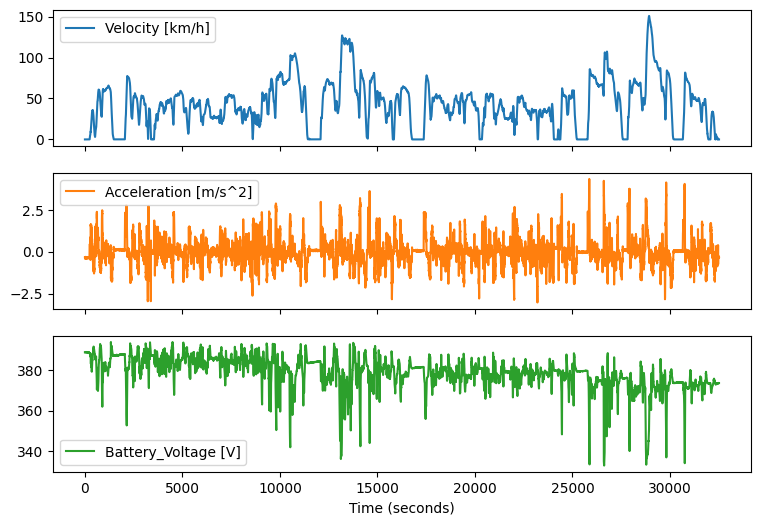

In [ ]:
df.plot(subplots = True, figsize = (9, 6))
plt.xlabel('Time (seconds)')

# Assumptions

>> Sampling rate of the signal Fs is 10 Hz

>> Measurements recorded at 100 ms (0.1 s) interval

Text(0, 0.5, 'Acceleration_RMS')

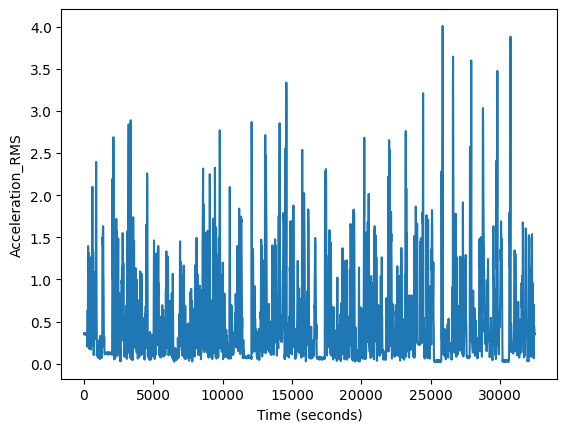

In [ ]:
N = data.shape[0]      #length of the array = number of samples
time = data['Time [s]']
Fs = 10     #Hz
T = 1/Fs    #T is aquisition time
accel = df['Acceleration [m/s^2]']

w = np.floor(Fs)                #window width for computing RMS
w = w.astype(int)
#steps = np.int(np.floor(N/w))
steps = N                       #number of steps for RMS
t_RMS = np.zeros((steps, 1))    #create array for RMS time values
x_RMS = np.zeros((steps, 1))    #create array for RMS values
for i in range (0, steps):
	t_RMS[i] = np.mean(time[(i*w):((i+1)*w)])
	x_RMS[i] = np.sqrt(np.mean(accel[(i*w):((i+1)*w)]**2))

x_RMS[np.isnan(x_RMS)] = 0

plt.figure()
plt.plot(t_RMS, x_RMS)
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration_RMS')

In [ ]:
data = data.drop('Acceleration [m/s^2]', axis = 1)
#data.head()
accel_rms = np.concatenate(x_RMS, axis = 0)
dff = pd.DataFrame({'Acceleration_rms (g)': accel_rms})

sample_df = pd.concat([data, dff], axis = 1)
print(sample_df.shape)
sample_df.head(5)

(32518, 4)


,Time [s],Velocity [km/h],Battery_Voltage [V],Acceleration_rms (g)
0,0,0.0,388.8,0.354971
1,1,0.0,388.8,0.362511
2,2,0.0,388.8,0.348379
3,3,0.0,388.8,0.357616
4,4,0.0,388.8,0.359947


In [ ]:
#dff = pd.DataFrame({'Time': t_RMS.tolist(), 'Acceleration_rms': x_RMS.tolist()})
#dff.head(5)

>> **For unlabeled data, one can try segmenting/clustering the dataset into 3 based on 2 features - Velocity [km/h] & Acceleration_rms (g)**

>> For **labeled data (states as labels)**, one can build a Random Forest model for classification of the states.

In [ ]:
label_df = pd.read_csv('ss.csv')
print(label_df.shape)
label_df.sample(5)

(32518, 5)


,Time [s],Velocity [km/h],Battery_Voltage [V],Acceleration_rms,State
4033,4033,34.37124,389.21525,0.0,ACTIVE
28921,28921,149.97917,349.11918,0.0,ACTIVE
23435,23435,27.47064,378.70000,0.0,ACTIVE
23787,23787,38.48043,377.08437,0.0,ACTIVE
23879,23879,28.22579,382.13614,0.0,ACTIVE


# Model for classification

In [ ]:
from sklearn.preprocessing import LabelEncoder
from numpy import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#from collections import Counter

In [ ]:
label_df['State'].value_counts()

,count
State,
ACTIVE,28652
OFF,3062
IDLE,804


>> Label encoding for categories

In [ ]:
le = LabelEncoder()
label_df['State'] = le.fit_transform(label_df['State']).astype('str')

label_df['State'].value_counts()

,count
State,
0,28652
2,3062
1,804


>> Feature Scaling

In [ ]:
label_df = label_df.drop('Time [s]', axis = 1)

df_column_names = list(label_df.columns)
df_column_names.remove('State')

x = label_df.loc[:, label_df.columns != 'State'].values          #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(data = x_scaled, columns = df_column_names)
df_normalized.head(5)

,Velocity [km/h],Battery_Voltage [V],Acceleration_rms
0,0.0,0.915898,0.088529
1,0.0,0.915898,0.090409
2,0.0,0.915898,0.086885
3,0.0,0.915898,0.089189
4,0.0,0.915898,0.089770


In [ ]:
df_normalized_target = pd.concat([df_normalized, label_df['State']], axis = 1)

X = df_normalized_target[list(df_normalized_target.columns)[0:3]]
print(X.shape)

Y = df_normalized_target[list(df_normalized_target.columns)[-1]]
print(Y.shape)

(32518, 3)
(32518,)


>> Data split into train and test subsets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42)
print(len(x_train), len(y_train))

24388 24388


>> **Classifier Model Training**

In [ ]:
rfc1 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
rfc1.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rfc_pred1 = rfc1.predict(x_test)

print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred1), 4))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred1))
print('Classification Report:')
print(classification_report(y_test, rfc_pred1))

Test Accuracy= 0.9999
Confusion Matrix (True label vs. Predicted label):
[[7164    1    0]
 [   0  173    0]
 [   0    0  792]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7165
           1       0.99      1.00      1.00       173
           2       1.00      1.00      1.00       792

    accuracy                           1.00      8130
   macro avg       1.00      1.00      1.00      8130
weighted avg       1.00      1.00      1.00      8130



[[7164    1    0]
 [   0  173    0]
 [   0    0  792]]
[[9.99860433e-01 1.39567341e-04 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


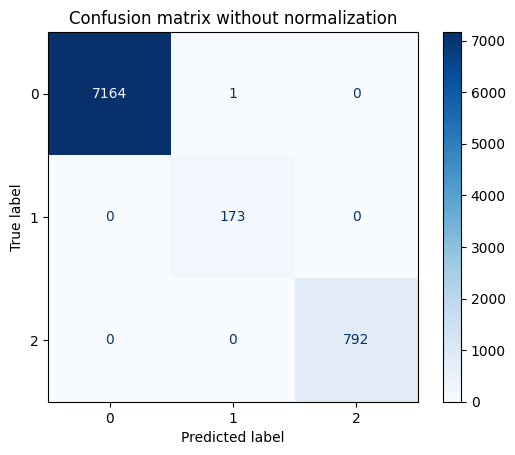

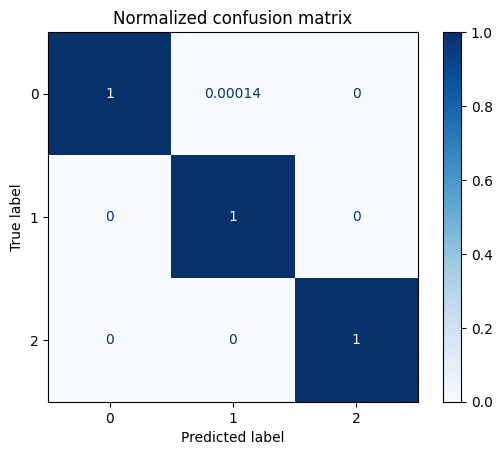

In [ ]:
def normalized_confusion_mat(model_obj, class_names, y):
    """
    Function: Displays normalized and non-normalized confusion matrices
    Arguments: Trained Model, class names' object, target test dataframe

    """

    titles_options = [
        ("Confusion matrix without normalization", None),
        ("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
            model_obj,
            x_test,
            y,
            display_labels = class_names,
            cmap = plt.cm.Blues,
            normalize = normalize,
        )
      disp.ax_.set_title(title)
      print(disp.confusion_matrix)

normalized_confusion_mat(rfc1, rfc1.classes_, y_test)

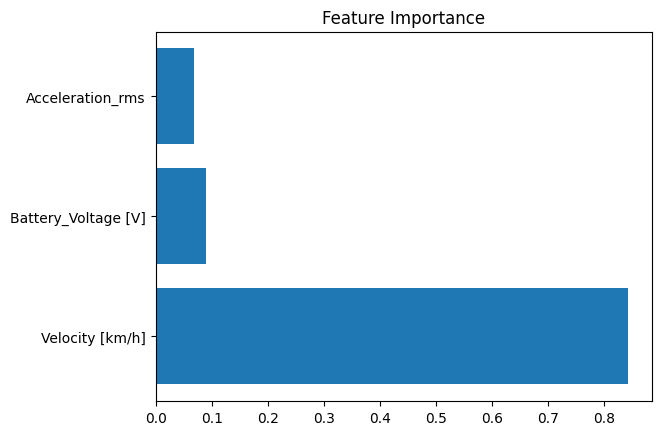

In [ ]:
plt.barh(df_normalized.columns, rfc1.feature_importances_)
plt.title ('Feature Importance')
plt.show()

>> Classifier model training with other criterion (hyperparameter)

In [ ]:
rfc2 = RandomForestClassifier(criterion = "entropy", n_estimators = 100, random_state = 42)
rfc2.fit(x_train, y_train)
#print(rfc2.get_params())

RandomForestClassifier(criterion='entropy', random_state=42)

In [ ]:
rfc_pred2 = rfc2.predict(x_test)

print ("Test Accuracy=", round(metrics.accuracy_score(y_test, rfc_pred2), 4))
print('Confusion Matrix (True label vs. Predicted label):')
print(confusion_matrix(y_test, rfc_pred2))
print('Classification Report:')
print(classification_report(y_test, rfc_pred2))

Test Accuracy= 0.9999
Confusion Matrix (True label vs. Predicted label):
[[7164    1    0]
 [   0  173    0]
 [   0    0  792]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7165
           1       0.99      1.00      1.00       173
           2       1.00      1.00      1.00       792

    accuracy                           1.00      8130
   macro avg       1.00      1.00      1.00      8130
weighted avg       1.00      1.00      1.00      8130



>> Gini index tends to be less sensitive to class imbalance, as it works to minimize the misclassification error. Entropy is sensitive to class imbalance in data, as it works by minimizing the log loss. Results remain same though with both criteria for this use-case or dataset.

>> The predictions of a model change when the *probability or decision threshold* changes. By default, the threshold is set to 0.5 in scikit-learn.

>> For labeled data, XGBoost classifier model could also be used.  